Available as executable Jupyter Notebook:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/HIL-HK/lets-plot-examples/master?filepath=plans%2Fcovid-19_in_China_except_Hubei.ipynb)

# COVID-19 Statistics in China (except Hubei) #

Data comes from [nCoV2019](https://github.com/beoutbreakprepared/nCoV2019) repository by reference from the paper [Open access epidemiological data from the COVID-19 outbreak](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30119-5/fulltext).


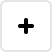
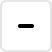
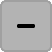
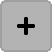
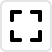
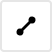
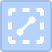

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn import cluster

from ipywidgets import widgets
from IPython.display import display

from lets_plot import *
LetsPlot.setup_html()

In [2]:
MAX_CLUSTERS_COUNT = 10

In [3]:
def player_widget(plots, *, fps=1):
    interval = max(1, int(1000 / fps))
    player = widgets.Play(min=0, max=len(plots) - 1, step=1, value=0, interval=interval)
    slider = widgets.IntSlider(min=0, max=len(plots) - 1, step=1, value=0)
    widgets.jslink((player, 'value'), (slider, 'value'))
    widget = widgets.HBox([player, slider])
    iout = widgets.interactive_output(lambda n, m: display(plots[n]), {'n': slider, 'm': player})
    return display(widget, iout)

In [4]:
def find_best_clustering(shapely_points, *, max_clusters_count=1, clusters_limit_proportion=.02, \
                         attempts_count=1, method=cluster.KMeans):
    points = shapely_points.apply(lambda p: [p.x, p.y]).to_list()
    max_clusters_count = min(max_clusters_count, len(set([str(p) for p in points])))
    if max_clusters_count < 1:
        return None
    for n in range(max_clusters_count, 0, -1):
        clustering = method(n_clusters=n, n_jobs=attempts_count).fit(points)
        clusters, counts = np.unique(clustering.labels_, return_counts=True)
        if clusters_limit_proportion <= np.min(counts) / np.max(counts):
            return clustering
    assert(False)

In [5]:
def append_cluster_column(gdf, *, distinguished_columns=[], max_clusters_count=1, cluster_column_name='cluster'):
    if any(distinguished_columns):
        column = distinguished_columns[0]
        return pd.concat([
            append_cluster_column(gdf[gdf[column] == value].copy(), \
                                  distinguished_columns=distinguished_columns[1:], \
                                  max_clusters_count=max_clusters_count, \
                                  cluster_column_name=cluster_column_name)
            for value in gdf[column].value_counts().keys()
        ])
    else:
        gdf[cluster_column_name] = find_best_clustering(gdf.geometry, max_clusters_count=max_clusters_count).labels_
        return gdf

In [6]:
def get_clusters_gdf_old(gdf, current_date):
    actual_gdf = gdf[gdf.date_confirmation<=current_date]
    
    vc = actual_gdf.cluster.value_counts()
    clusters, counts = vc.keys(), vc.values
    geometry = [gdf[gdf.cluster == cluster].unary_union.centroid for cluster in clusters]
    
    return gpd.GeoDataFrame(dict(cluster=clusters, \
                                 count=counts, \
                                 date=[current_date]*len(clusters), \
                                 geometry=geometry))

In [7]:
def diseased_count(outcome_series):
    return outcome_series.size

def died_count(outcome_series):
    return outcome_series[outcome_series == 'died'].size

def get_clusters_gdf(gdf, current_date):
    actual_gdf = gdf[gdf.date_confirmation<=current_date]
    clusters_gdf = actual_gdf.groupby(['cluster'], as_index=False).agg({'outcome': [diseased_count, died_count]})
    clusters_gdf['geometry'] = [gdf[gdf.cluster == cluster].unary_union.centroid for cluster in clusters_gdf.cluster]
    clusters_gdf['date'] = current_date
    clusters_gdf.columns = [column[1] if column[1] else column[0] for column in clusters_gdf.columns]
    return clusters_gdf

In [8]:
# Read the map polygon
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
china = world[world.name == 'China']

In [9]:
# Prepare dataframe
columns = ['date_confirmation', 'outcome', 'date_death_or_discharge', 'country', 'latitude', 'longitude']
except_hubei_data = pd.read_csv('https://raw.githubusercontent.com/HIL-HK/lets-plot-examples/master/data/covid-19/disease_data.csv', low_memory=False, error_bad_lines=False)
df = pd.DataFrame(except_hubei_data)[columns]

In [10]:
# Clean data
df = df[~df.latitude.isna()]
df = df[~df.longitude.isna()]
df = df[~df.date_confirmation.isna()]
df = df[df.country == 'China']
df = df[~(((df.outcome=='discharged')|(df.outcome=='died'))&df.date_death_or_discharge.isna())]

In [11]:
# Fix data
df.latitude = df.latitude.astype(float)
df.longitude = df.longitude.astype(float)
df.date_confirmation = pd.to_datetime(df.date_confirmation, dayfirst=True, errors='coerce')\
    .apply(lambda dt: dt.replace(year=2020))
df.date_death_or_discharge = pd.to_datetime(df.date_death_or_discharge, dayfirst=True, errors='coerce')\
    .apply(lambda dt: dt.replace(year=2020))
df.outcome = df.outcome.replace({'discharge': 'discharged'})\
    .apply(lambda outcome: outcome if outcome in df.outcome.unique() else 'diseased')

In [12]:
# Prepare geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf[gdf.within(china.iloc[0].geometry)]

In [13]:
# Add clusters by geoposition
gdf = append_cluster_column(gdf, max_clusters_count=MAX_CLUSTERS_COUNT)

In [14]:
sorted_dates = gdf.date_confirmation.sort_values().unique()

In [15]:
clusters_gdf = gpd.GeoDataFrame(pd.concat([
    get_clusters_gdf(gdf, current_date)
    for current_date in sorted_dates
]).reset_index(drop=True))

In [16]:
p = ggplot() + \
    geom_polygon(data=china, fill='#d6d6d6') + \
    theme(legend_position='none', axis_title='blank', axis_text='blank', axis_ticks='blank', axis_line='blank') + \
    ggsize(600, 600)

limit = clusters_gdf.diseased_count.max()
plots = []
for current_date in sorted_dates:
    current_clusters_gdf = clusters_gdf[clusters_gdf.date == current_date]
    plots.append(
        p + \
        geom_point(aes(geometry='centroid', size='diseased_count', color='died_count'), data=current_clusters_gdf) + \
        scale_size(name='Count of cases', limits=[0, limit], range=[2, 30]) + \
        scale_color_gradient(name='Count of deaths', low='#feb24c', high='#e31a1c') + \
        ggtitle('COVID-19 on ' + np.datetime_as_string(current_date, unit='D'))
    )

In [17]:
player_widget(plots)

Output()